In [1]:
import numpy as np
from matplotlib import pyplot as plt
# import sys
# sys.path.append('../jiarongw-postprocessing/jupyter_notebook/project_specific/turbulence')
# sys.path.append('../jiarongw-postprocessing/jupyter_notebook/project_specific/multilayer')
# sys.path.append('../jiarongw-postprocessing/jupyter_notebook/functions')

# from spectrum_func import cart2pol

### Apply phase shift to the wave field by multiplication of Fourier modes
This might be a way to implement wind forcing in multi-layer simulations.

In [2]:
# I take a snapshot of instantaneous eta
path = '/Users/jiarongw/Data/multilayer/JFM2023/field_new_200m_P0.02_RE40000_10_15_rand2_Htheta0.503/'
N = 1024; L = 200

t = 180 # choice of time
filename = path + 'surface/eta_matrix_%g' %t
eta = np.fromfile(filename, dtype=np.float32)
eta = eta.reshape(N+1,N+1); eta = eta[1:,1:]

# wavenumber = 2*np.pi*np.fft.fftfreq(n=N,d=L/N)
# spectrum = np.fft.fft2(eta) / (N*N)**0.5 # FFT normalization 
# F = np.absolute(spectrum)**2 / N**2 # Per area normalization

In [8]:
# Previously I was using fft and trying to figure out the quadrants myself
# mag = 1
# phase = np.pi/4. 
# phase_shift_plus = mag*np.cos(phase) + mag*np.sin(phase)*1j
# phase_shift_minus = mag*np.cos(-phase) + mag*np.sin(-phase)*1j
# spectrum = np.fft.fft2(eta)
# spectrum_shift = np.copy(spectrum)
# spectrum_shift[1:512,1:512] = spectrum_shift[1:512,1:512]*phase_shift_plus
# spectrum_shift[512:,512:] = spectrum_shift[512:,512:]*phase_shift_minus
# spectrum_shift[1:512,512:] = spectrum_shift[1:512,512:]*phase_shift_plus
# spectrum_shift[512:,1:512] = spectrum_shift[512:,1:512]*phase_shift_minus
# forcing = np.fft.ifft2(spectrum_shift)

# I'm not getting real signal; Pavel says that it should be 10^{-15} if double precision
# np.abs(np.imag(forcing)).max() / np.abs(np.real(forcing)).max()

# And then Pavel says "Just use rfft."

In [3]:
# Use real fft
spectrum = np.fft.rfft2(eta)

mag = 1 # The magnitude can be extracted from DNS, and can be different for different c/u*
phase = np.pi/4. # The phase shift can be a function of wave modes too
phase_shift_plus = mag*np.cos(phase) + mag*np.sin(phase)*1j
phase_shift_minus = mag*np.cos(-phase) + mag*np.sin(-phase)*1j

spectrum_shift = np.copy(spectrum)
spectrum_shift = spectrum_shift*phase_shift_plus
forcing = np.fft.irfft2(spectrum_shift) # And we can potentially add stochasticity to the forcing field

correlation: 0.0912163


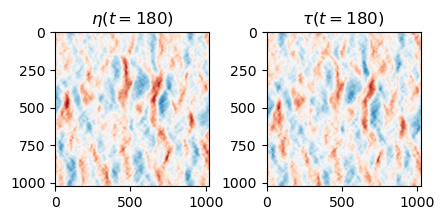

In [4]:
# It looks reasonable and the correlation is close to 0 if phase=pi/2
# and positive for phase=pi/4 for example
fig, axes = plt.subplots(1,2,figsize=[5,2])
axes[0].imshow(np.rot90(eta), cmap='RdBu_r', vmax=1.6, vmin=-1.6)
axes[1].imshow(np.rot90(forcing), cmap='RdBu_r', vmax=1.6, vmin=-1.6)
axes[0].set_title('$\eta(t=180)$'); axes[1].set_title(r'$\tau(t=180)$')
print('correlation: %g' %np.average(eta*forcing))

/Users/jiarongw/miniconda3/envs/gp-tigressdata/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/jiarongw/miniconda3/envs/gp-tigressdata/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


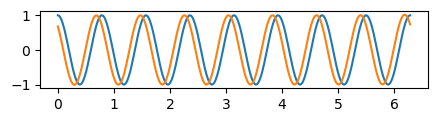

In [5]:
# An illustration in 1D, before I switched to rfft
plt.figure(figsize=[5,1])
x = np.linspace(0,2*np.pi,512)
signal = np.cos(8*x)
plt.plot(x,signal)

spectrum = np.fft.fft(signal)
mag = 1
phase = np.pi/4.
# phase = np.pi/2.
phase_shift_plus = mag*np.cos(phase) + mag*np.sin(phase)*1j
phase_shift_minus = mag*np.cos(-phase) + mag*np.sin(-phase)*1j

spectrum_shift = np.copy(spectrum)
spectrum_shift[1:256] = spectrum_shift[1:256]*phase_shift_plus
spectrum_shift[256:] = spectrum_shift[256:]*phase_shift_minus
forcing = np.fft.ifft(spectrum_shift)

plt.plot(x,forcing)

### About determining the left and right traveling modes
Demonstrate that we can determine the left vs right traveling modes from two adjacent snapshots assuming that everything is linear and dt is smaller than the wave period that we are interested in.

In [6]:
path = '/Users/jiarongw/Data/multilayer/JFM2023/field_new_200m_P0.02_RE40000_10_15_rand2_Htheta0.503/'
N = 1024; L = 200

t = 180 # choice of time
filename = path + 'surface/eta_matrix_%g' %t
eta = np.fromfile(filename, dtype=np.float32)
eta1 = eta.reshape(N+1,N+1); eta1 = eta1[1:,1:]

t = 180.1 # choice of time
filename = path + 'surface/eta_matrix_%g' %t
eta = np.fromfile(filename, dtype=np.float32)
eta2 = eta.reshape(N+1,N+1); eta2 = eta2[1:,1:]

spectrum1 = np.fft.rfft2(eta1)
spectrum2 = np.fft.rfft2(eta2)
kx = np.fft.rfftfreq(n=1024, d=200/1024)*2*np.pi
ky = np.fft.rfftfreq(n=1024, d=200/1024)*2*np.pi

0.028976489502118178

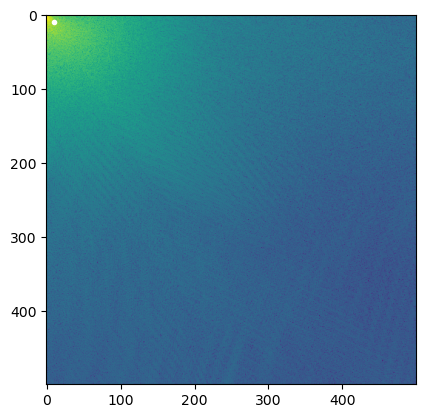

In [7]:
# Let's say we pick a mode 
plt.imshow(np.log(np.absolute(spectrum1[0:500,0:500])))
plt.plot(10,10,'.',c='white')
k = (kx[10]**2 + ky[10]**2)**0.5
omega = (k*9.8)**0.5

# It's a 2*2 matrix inversion 
dt = 0.1
theta = dt*omega
A = np.array([[1,1],[np.cos(theta)+np.sin(theta)*1j,np.cos(-theta)+np.sin(-theta)*1j]])
b = np.array([spectrum1[10,10],spectrum2[10,10]])
a1 = (b[1] - b[0]*A[1,1])/(A[1,0]-A[1,1])
a2 = b[0] - a1

# Ratio between right and left traveling modes is small. I say it's a success!
np.absolute(a1)/np.absolute(a2)